### Import Libraries

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Create Functions for Data Cleaning

**1. Rename columns** <br></br>

In [76]:
def rename(df, data_type):
    """Rename columns to appropriate fields"""
    
    if data_type == 'train':
        columns_new = ['id', 'cancel', 'year', 'zipcode', 'house_color', 'age', 'len_residence', 
                       'credit', 'plan', 'property', 'premium', 'channel', 'gender', 'married',
                       'adults', 'children', 'tenure', 'claim']
        df = df[df['cancel'] != -1]
    else:
        columns_new = ['id','tenure','claim','adults','children','gender','married','premium','channel',
                       'plan','property','len_residence','credit','house_color','age','year','zipcode']
    df.columns = columns_new
    
    return df

**2. Impute Missing values** <br></br>

In [77]:
def impute_nulls(df):
    """To impute missing data from both training set"""
    
    imputed_vals = {}
    numerical_cols = ['age', 'len_residence', 'premium', 'tenure']
    categorical_cols = ['year', 'zipcode', 'house_color', 'credit', 'plan', 'property', 
                        'channel', 'gender', 'married', 'adults', 'children', 'claim']
    for cols in numerical_cols:
        imputed_vals[cols] = df[cols].median()
    for cols in categorical_cols:
        imputed_vals[cols] = df[cols].mode()[0]
    
    return imputed_vals

**3. Clean Table** <br></br>

In [78]:
def clean_table(df, nulls_dict):
    """To clean dataset off missing values & irregular column data types"""
    
    # Fill nulls:
    for keys, values in nulls_dict.items():
        df[keys].fillna(values, inplace = True)
    
    # Change datatype:
    int_cols = ['year', 'zipcode', 'married', 'adults', 'children', 'tenure', 'claim']
    for cols in int_cols:
        df[cols] = df[cols].astype('int')
    
    cat_cols = ['house_color','credit', 'plan', 'property', 'channel', 'gender']
    for cols in cat_cols:
        df[cols] = df[cols].astype('category')
    
    
    # Clean Textual Info:
    str_cols = ['house_color', 'credit', 'property', 'channel']
    for cols in str_cols:
        df[cols] = df[cols].str.lower()
      
    
    # Int to String description of columns:
    indicator_cols = ['married', 'claim']
    for cols in indicator_cols:
        df[cols] = df[cols].apply(lambda x: 'Y' if x == 1 else 'N')
    
    return df

**4. Feature Engineering** <br></br>

In [79]:
def feature_engineering(df):
    """To create derived features"""
    
    # Create Zonal Data
    df['zone'] = df['zipcode'].astype(str).str[0:2]
    df['zone'] = df['zone'].astype('category')
    
    # Handle Age > 100:
    def age_bin(x):
        if x <= 25:
            return 'Under 25'
        elif x > 25 and x <= 35:
            return '25-35'
        elif x > 35 and x <= 45:
            return '35-45'
        elif x > 45 and x <= 60:
            return '45-60'
        else:
            return 'Above 60'
    
    df['age_bins'] = df['age'].apply(lambda x: age_bin(x))
    
    # Binning #children for Family Size
    df['num_children'] = df['children'].apply(lambda x: '0' if x == 0 else ('LE3' if x <= 3 else 'G3'))
    
    # Binning #adults for Family Size
    df['num_adults'] = df['adults'].apply(lambda x: '1' if x == 1 else ('2' if x == 2 else 'G2'))
    
    return df

**5. One-Hot Encoding** <br></br>

In [80]:
def categorical_encoding(df, formula, interaction_cols, dummy_cols):
    """To create dummy variables for categorical columns in both training & test datasets"""
    
    # Create Interaction Terms
    #X_inter = []
    #for f in formula:
    #    X_inter.append(dmatrix(f+' -1', df, return_type = "dataframe"))
    
    # Create dummy variables
    df = pd.get_dummies(data = df, columns = interaction_cols + dummy_cols, drop_first = True)
    
    # Combine
    #for X in X_inter:
    #    df = pd.concat([X, df], axis = 1)
    
    return df

## Execute Main Program: Statistical Model Creation

**1. Load Dataset** <br></br>

In [81]:
data = pd.read_csv('train.csv')

**2. Data Cleaning & Feature Engineering using custom functions** <br></br>

In [82]:
data = rename(df = data, data_type = 'train')
values = impute_nulls(df = data)
data = clean_table(df = data, nulls_dict = values)
data = feature_engineering(df = data)

**3. Create Interaction Terms & One-Hot Encoding**

In [83]:
from patsy import dmatrix

#formula = ['credit:channel', 'credit:zone', 'credit:age_bins', 'credit:married']
formula = []
inter_cols = ['credit','channel','zone','age_bins','married']
dummy_columns = ['year','plan','property','gender','claim','num_children','num_adults']
data_encoded = categorical_encoding(df = data, formula = formula, interaction_cols = inter_cols, dummy_cols = dummy_columns)

**4. Set Response (Y) & Predictor variables (X)**

In [84]:
drop_columns = ['id', 'cancel', 'zipcode', 'house_color', 'adults', 'age',
                'children', 'gender_M', 'premium', 'tenure', 'len_residence']
all_columns = set(data_encoded.columns)
list_X = list(all_columns.difference(set(drop_columns)))
X = data_encoded[list_X]
y = data_encoded['cancel']

**5. Training Set & Validation Set Split** <br></br>

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

**6. Multinomial Logistic Regression Model**

$\space\space\space\space\space\space$ A. Without Interaction terms

In [22]:
from sklearn.linear_model import LogisticRegression
from warnings import filterwarnings
filterwarnings('ignore')

mlogit_model = LogisticRegression(multi_class = 'ovr').fit(X_train, y_train)

In [12]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, mlogit_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, mlogit_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.7250926922616912
Precision: 0.6520866034454588


In [13]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(mlogit_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted       0      2
Actual                  
0          107463  11056
1           11003   1131
2           33012   3341


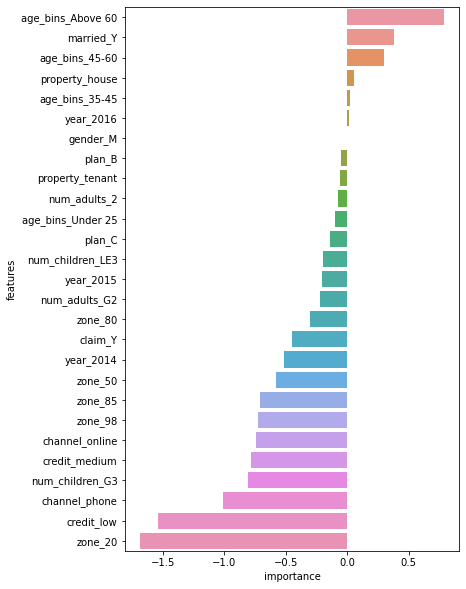

In [14]:
dt = pd.DataFrame(zip(list_X, mlogit_model.coef_[0]), columns = ['features', 'importance'])
dt.sort_values(by = 'importance', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (6, 10))
sns.barplot(x = 'importance', y = 'features', data = dt)
plt.show()

$\space\space\space\space\space\space$ B. With Interaction terms

In [23]:
from sklearn.linear_model import LogisticRegression
from warnings import filterwarnings
filterwarnings('ignore')

mlogit_model = LogisticRegression(multi_class = 'ovr').fit(X_train, y_train)

In [24]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, mlogit_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, mlogit_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.7242913527090061
Precision: 0.6507686039020166


In [25]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(mlogit_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted      0     2
Actual                
0          27075  2723
1           2732   273
2           8365   816


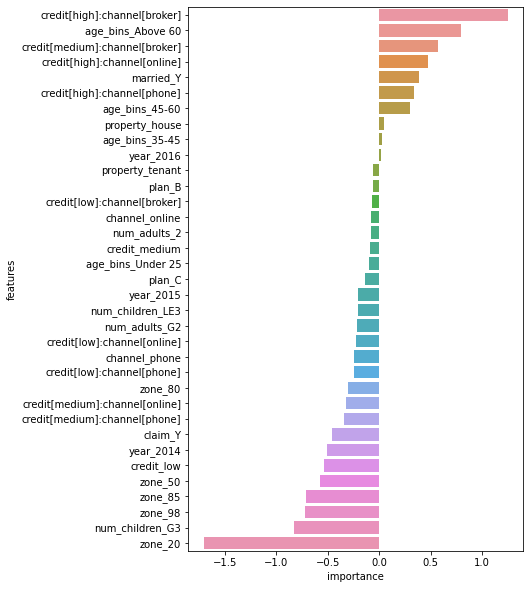

In [26]:
dt = pd.DataFrame(zip(list_X, mlogit_model.coef_[0]), columns = ['features', 'importance'])
dt.sort_values(by = 'importance', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (6, 10))
sns.barplot(x = 'importance', y = 'features', data = dt)
plt.show()

### LDA

A. Without Interaction Terms

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [16]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, lda_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, lda_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.7239086233704103
Precision: 0.6501643069738292


In [17]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(lda_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted       0      2
Actual                  
0          105849  12670
1           10857   1277
2           32492   3861


B. With Interaction Terms

In [201]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [202]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, lda_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, lda_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.721109915081928
Precision: 0.6494729314551991


In [203]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(lda_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted      0   1     2
Actual                    
0          26568  99  3131
1           2687   3   315
2           8209  28   944


### QDA

A. Without Interaction Terms

In [18]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

In [19]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, qda_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, qda_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.6918670015548379
Precision: 0.6742664741741251


In [20]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(qda_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted      0     1      2
Actual                       
0          90350  8041  20128
1           9207   857   2070
2          27754  2450   6149


B. With Interaction Terms

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

In [28]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, qda_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, qda_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.4387609137662959
Precision: 0.6734078615793799


In [29]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(qda_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted     0     1      2
Actual                      
0          9932  7515  12351
1          1047   728   1230
2          3099  2287   3795


### Naive Bayes

A. Without Interaction Terms

In [30]:
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB() 
nv.fit(X_train,y_train)

GaussianNB()

In [22]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, nv.predict(X_test))}")
print(f"Precision: {precision_score(y_test, nv.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.6925343858390145
Precision: 0.6410038548814574


In [23]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(nv.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted      0    1      2
Actual                      
0          95496  927  22096
1           9765  104   2265
2          29288  273   6792


B. With Interaction Terms

In [31]:
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB() 
nv.fit(X_train,y_train)

GaussianNB()

In [32]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, nv.predict(X_test))}")
print(f"Precision: {precision_score(y_test, nv.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.6482813060638679
Precision: 0.6851960080623232


In [33]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(nv.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted      0     1     2
Actual                      
0          20921  5472  3405
1           2122   535   348
2           6485  1716   980


### DecisionTree Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=5, min_samples_leaf=5)   
clf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

In [30]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, clf_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, clf_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.7197942829805047
Precision: 0.64161651053092


In [31]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(clf_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted       0     2
Actual                 
0          108966  9553
1           11173   961
2           33457  2896


In [34]:
from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=5, min_samples_leaf=5)   
clf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

In [35]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, clf_model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, clf_model.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.7193158713072599
Precision: 0.6405318866958528


In [36]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(clf_model.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted      0     2
Actual                
0          27344  2454
1           2736   269
2           8458   723


## XGBoost Classfier

A. Without Interaction Terms

In [86]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

[04:16:59] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [87]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, xgbc.predict(X_test))}")
print(f"Precision: {precision_score(y_test, xgbc.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.724951560818084
Precision: 0.6756911434398322


In [88]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(xgbc.predict(X_test), name='Predicted')
print(pd.crosstab(y_actual, y_predicted))

Predicted      0    1     2
Actual                     
0          27132  108  2558
1           2730   13   262
2           8354   43   784


B. With Interaction Terms

In [46]:
cols = []
for c in X_train.columns:
    cols.append(c.replace(':',' ').replace('[',' ').replace(']', ' '))
X_train.columns = cols

In [47]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

[04:07:02] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [48]:
from sklearn.metrics import accuracy_score, precision_score
print(f"Accuracy: {accuracy_score(y_test, xgbc.predict(X_test))}")
print(f"Precision: {precision_score(y_test, xgbc.predict(X_test), average = 'weighted', zero_division = 0)}")

Accuracy: 0.7248176055495754
Precision: 0.67709789866112


In [49]:
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(xgbc.predict(X_test), name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted      0    1     2
Actual                     
0          27089  149  2560
1           2733   13   259
2           8367   50   764


## Prediction using Test Data

**1. Load Test Dataset** <br></br>

In [89]:
test = pd.read_csv('test.csv')
test.head()

,id,tenure,claim.ind,n.adults,n.children,ni.gender,ni.marital.status,premium,sales.channel,coverage.type,dwelling.type,len.at.res,credit,house.color,ni.age,year,zip.code
0,7583,5.0,0.0,1.0,3,F,1.0,913.623201,Broker,C,Tenant,18.0,medium,blue,35.0,2017,85066.0
1,7584,15.0,1.0,1.0,4,F,1.0,1018.426114,Phone,A,House,15.0,medium,white,59.0,2017,98013.0
2,7585,1.0,1.0,3.0,2,M,1.0,928.418533,Broker,B,Condo,13.0,medium,blue,27.0,2017,15049.0
3,7586,12.0,0.0,4.0,0,M,0.0,877.649917,Broker,B,Condo,19.0,high,blue,35.0,2017,15026.0
4,7587,11.0,0.0,1.0,9,F,1.0,947.281913,Broker,A,Condo,18.0,high,red,34.0,2017,15025.0


**2. Test Data Cleaning using custom functions** <br></br>

In [90]:
test = rename(df = test, data_type = 'test')
test = clean_table(df = test, nulls_dict = values)

# Additional cleaning step:
test['property'] = test['property'].apply(lambda x: 'house' if x == 'landlord' else x)

test = feature_engineering(df = test)
test_with_dummies = categorical_encoding(df = test, formula = formula, interaction_cols = inter_cols, dummy_cols = dummy_columns)

**3. Prediction**

In [91]:
drop_columns = ['id', 'zipcode', 'house_color', 'age', 'adults', 'children', 'gender_M', 'premium', 'tenure', 'len_residence']
all_columns = set(test_with_dummies.columns)
list_X_test = list(all_columns.difference(set(drop_columns)))

missing_features = set(list_X).difference(set(list_X_test))
for cols in missing_features:
    test_with_dummies[cols] = 0
    
X_test = test_with_dummies[list_X]
test['predicted'] = xgbc.predict(X_test)

**4. Export Output**

In [92]:
#test[['id','predicted']].to_csv('output3.csv')